# QAOA算法

在本教程中，我们将使用DeepQuantum实现量子近似优化算法(QAOA)，以求解最大割问题。该算法最初由Farhi等人在2014年提出[1]。首先，我们用一个简单的例子——一个有4个顶点和4条边的图，来概述最大割问题。然后,我们展示如何通过运行QAOA算法，利用DeepQuantum找到最大割。

背景知识
========

最大割问题
----------

最大割问题的目标是最大化图中被划分的顶点（圆圈）分成两部分时所"割断"的边数（线段）。如下图所示:

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./images/qaoa_maxcut_partition.png" width="40%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

考虑一个有 $m$ 条边和 $n$ 个顶点的图。我们寻求将顶点划分为两个集合 $A$ 和 $B$ 的最优划分方案 $z$ ，使得下式最大化:

$$C(z) = \sum_{\alpha=1}^{m}C_\alpha(z)$$

其中 $C$ 统计割断的边数。如果 $z$ 将第 $\alpha$ 条边的一个顶点放在集合 $A$ 中，另一个顶点放在集合 $B$ 中，则 $C_\alpha(z)=1$ ；否则 $C_\alpha(z)=0$ 。寻找一个使 $C$ 达到最大值的割是一个典型的NP完全问题，因此我们只能依赖多项式时间内的近似算法来进行优化。在最大割问题中，我们需要找到一个顶点分配 $z$ ，使得 $C(z)$ 的值尽可能接近最大可能值。

顶点到集合 $A$ 或 $B$ 的分配可以通过一个二进制字符串 $z=z_1...z_n$ 来表示，其中 $z_i=0$ 代表第 $i$ 个顶点位于集合 $A$ 内，而 $z_i=1$ 则代表其位于集合 $B$ 内。例如，在之前提到的图中，二进制字符串可以表示成 $z=0101$，这意味着第 $0$ 和第 $2$ 个顶点位于集合 $A$，而第 $1$ 和第 $3$ 个顶点位于集合 $B$，这样的分配使得割断的边的数量 $C$ 达到了4，这也恰好是该图的最大割。在后续的内容中，我们将探讨如何利用DeepQuantum来计算基态，从而找出这样的最大割配置。

最大割问题的量子近似优化算法线路设计
------------------------------------

这里介绍如何使用基本的量子门构建求解最大割问题的量子近似优化算法（QAOA）线路，以找到近似最优解。首先，我们用计算基态 $|z\rangle$ 表示图的划分，目标函数中的每一项可以表示为作用在这些态上的算符：

$$C_\alpha = \frac{1}{2}\left(1-\sigma_{z}^j\sigma_{z}^k\right),$$

其中第 $\alpha$ 条边连接顶点 $(j,k)$。当且仅当第 $j$ 个和第 $k$ 个量子比特的 z 轴测量值不同时，表示它们属于不同的子集，此时 $C_\alpha$ 的本征值为1。目标函数 $C$ 可以看作一个具有整数本征值的对角算符。

QAOA 从 $n$ 个计算基态的均匀叠加态开始：

$$|+_{n}\rangle = \frac{1}{\sqrt{2^n}}\sum_{z\in \{0,1\}^n} |z\rangle.$$

我们的目标是探索比特串态空间，寻找一个在计算基测量下能够得到较大 $C$ 值的叠加态。利用 $2p$ 个角度参数 $\boldsymbol{\gamma} = \gamma_1\gamma_2...\gamma_p$，$\boldsymbol{\beta} = \beta_1\beta_2...\beta_p$，对初态进行一系列操作：

$$|\boldsymbol{\gamma},\boldsymbol{\beta}\rangle = U_{B_p}U_{C_p}U_{B_{p-1}}U_{C_{p-1}}...U_{B_1}U_{C_1}|+_n\rangle$$

其中算符的具体形式为：

$$\begin{aligned}
U_{B_l} &= e^{-i\beta_lB} = \prod_{j=1}^n e^{-i\beta_l\sigma_x^j}, \\
U_{C_l} &= e^{-i\gamma_lC} = \prod_{\text{edge (j,k)}} e^{-i\gamma_l(1-\sigma_z^j\sigma_z^k)/2}.
\end{aligned}$$

换言之，我们构建了 $p$ 层参数化的 $U_bU_C$ 门。它们可以用下图所示的量子门来实现，忽略一个与参数无关的常数项。

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./images/qaoa_operators.png" width="40%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>

令 $\langle \boldsymbol{\gamma},
\boldsymbol{\beta} | C | \boldsymbol{\gamma},\boldsymbol{\beta} \rangle$ 为目标算符的期望值。下一节中，我们将使用DeepQuantum对线路参数 $(\boldsymbol{\gamma}, \boldsymbol{\beta})$ 进行经典优化，以确定一个态 $|\boldsymbol{\gamma},\boldsymbol{\beta}\rangle$，使得在计算基上测量时有较大概率得到近似最优划分 $|z\rangle$。对于上图所示的图，我们希望从优化后的量子态测量到 0101 或 1010，因为它们对应着最优划分。

<div style="margin-right: 15px; border-radius: 10px; background-color: rgb(255， 255， 255); text-align: center;">
    <img src="./images/qaoa_optimal_state.png" width="40%"/>
    <p style="padding: 10px; font-size: small; text-align: center; line-height: 0%;">
        <b>
    </p>
</div>


从直观上讲，QAOA 试图将初态演化到 $|0101\rangle$, $|1010\rangle$ 构成的平面内（如上图所示）。

在 DeepQuantum 中实现 QAOA
=======================

首先，我们导入 DeepQuantum 和其他相关的库。

In [1]:
import deepquantum as dq
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt

用 `qubit_num` 指定量子比特（顶点）数，并根据上面的定义构造酉算符。$U_B$ 算符作用在单个量子线路上，而 $U_C$ 算符作用在图中有边相连的顶点对应的量子线路上。我们还用元组列表 `graph` 定义图，其中每个元组表示图中的一条边。

接下来，我们创建一个有 4 个量子比特的量子设备。

我们还需要一个量子节点，根据角度参数施加算符，并返回可观测量 $\sigma_z^{j}\sigma_z^{k}$ 的期望值，用于后面目标函数中的每一项。参数 `edge` 指定目标函数中选择的边项 $(j,k)$。一旦优化完成，将 `edge` 设为 `None`，就可以用同一个量子节点对线路进行采样，得到近似最优比特串。我们用 `n_layers` 指定电路层数（$U_BU_C$ 的重复次数）。

最后，我们在角度参数 $\boldsymbol{\gamma}$ (`gamma[k]`) 和 $\boldsymbol{\beta}$ (`beta[k]`) 上优化目标函数，然后对优化后的电路进行多次采样，得到比特串分布。其中一个最优划分（$z=0101$ 或 $z=1010$）应当是采样频率最高的比特串。我们通过最小化 $-C$ 来最大化 $C$，以遵循 DeepQuantum 中把优化问题统一表述为最小化问题的约定。


In [2]:
import deepquantum as dq
import torch
import torch.nn as nn
from typing import Dict,List, Tuple

class QAOA(nn.Module):
    def __init__(self, qubit_num: int, graph: List[Tuple[int, int]], n_layers: int):
        super(QAOA, self).__init__()
        self.qubit_num = qubit_num
        self.gamma = nn.Parameter(0.1 * torch.ones(n_layers, requires_grad=True))
        self.beta = nn.Parameter(torch.ones(n_layers, requires_grad=True))
        
        self.cir = self._build_circuit(graph, n_layers)
        
    def _build_circuit(self, graph: List[Tuple[int, int]], n_layers: int) -> dq.QubitCircuit:
        cir = dq.QubitCircuit(self.qubit_num)
        cir.hlayer()
        cir.barrier()
        
        for j in range(n_layers):  # n_layers量子网络演化步数，步数越高计算越精确
            self._apply_uc_gates(cir, graph)
            self._apply_ub_gates(cir)
        
        self._apply_observable(cir, graph)
        
        return cir
    
    def _apply_uc_gates(self, cir: dq.QubitCircuit, graph: List[Tuple[int, int]]):
        for edge in graph:  # Uc项
            cir.cnot(edge[0], edge[1])
            cir.rz(edge[1], encode=True)
            cir.cnot(edge[0], edge[1])
            cir.barrier()
    
    def _apply_ub_gates(self, cir: dq.QubitCircuit):
        for i in range(self.qubit_num):  # Ub项
            cir.rx(i, encode=True)
        cir.barrier()
    
    def _apply_observable(self, cir: dq.QubitCircuit, graph: List[Tuple[int, int]]):
        for edge in graph:  # 测量每一项
            cir.observable(wires=[edge[0], edge[1]], basis='z')
    
    def draw(self) -> str:  # 画出量子线路图
        return self.cir.draw()
 
    def measure(self) -> List[int]:  # 测量线路
        return self.cir.measure(wires=list(range(self.qubit_num)))
    
    def forward(self) -> torch.Tensor:
        parameter_all = torch.empty((len(self.gamma), len(graph) + self.qubit_num))
        
        for k in range(len(self.gamma)):
            parameter1 = 2 * self.gamma[k].repeat(len(graph))
            parameter2 = 2 * self.beta[k].repeat(self.qubit_num)
            parameter_all[k] = torch.cat((parameter1, parameter2), dim=0)
        
        parameter_all = parameter_all.reshape(-1)
        self.cir(parameter_all)
        return sum(self.cir.expectation()[0])  # 测量的哈密顿量可能需要根据具体的问题进行一定的修改

定义了一个名为 `trainer` 的函数，用于训练一个QAOA模型。函数接受三个参数：`model`（要训练的模型对象），`epoch`（训练的轮数），以及 `learning_rate`（学习率）。

In [3]:
def trainer(model: torch.nn.Module, epochs: int, learning_rate: float) -> Tuple[torch.nn.Module, Dict[str, List[float]]]:
    # 选择优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.RMSprop(model.parameters(),learning_rate,alpha=0.99,eps=1e-08,weight_decay=0,momentum=0,centered=False)
    
    train_loss_list=[]
    for epoch in range(epochs):
        y_pred = model()
        loss = y_pred
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_list.append(loss.item())
        print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

    # torch.save(model.state_dict(), save_path+model_type+'.pt')   # 保存训练好的模型参数，用于后续的推理或测试

    
    metrics = {
        'epoch': list(range(1, epochs+1)),
        'train_loss': train_loss_list
    }
    return model, metrics



In [4]:
# # 示例
qubit_num = 4
graph = [[0, 1], [1, 2], [2, 3], [3, 0]]
n_layers = 2
epochs=10
learning_rate=0.01

qaoa = QAOA(qubit_num, graph, n_layers)
optim_model, metrics = trainer(qaoa, epochs, learning_rate)

Epoch: 1/10, Loss: 0.0818
Epoch: 2/10, Loss: -0.0817
Epoch: 3/10, Loss: -0.2469
Epoch: 4/10, Loss: -0.4114
Epoch: 5/10, Loss: -0.5727
Epoch: 6/10, Loss: -0.7287
Epoch: 7/10, Loss: -0.8769
Epoch: 8/10, Loss: -1.0154
Epoch: 9/10, Loss: -1.1423
Epoch: 10/10, Loss: -1.2561


画出量子线路图

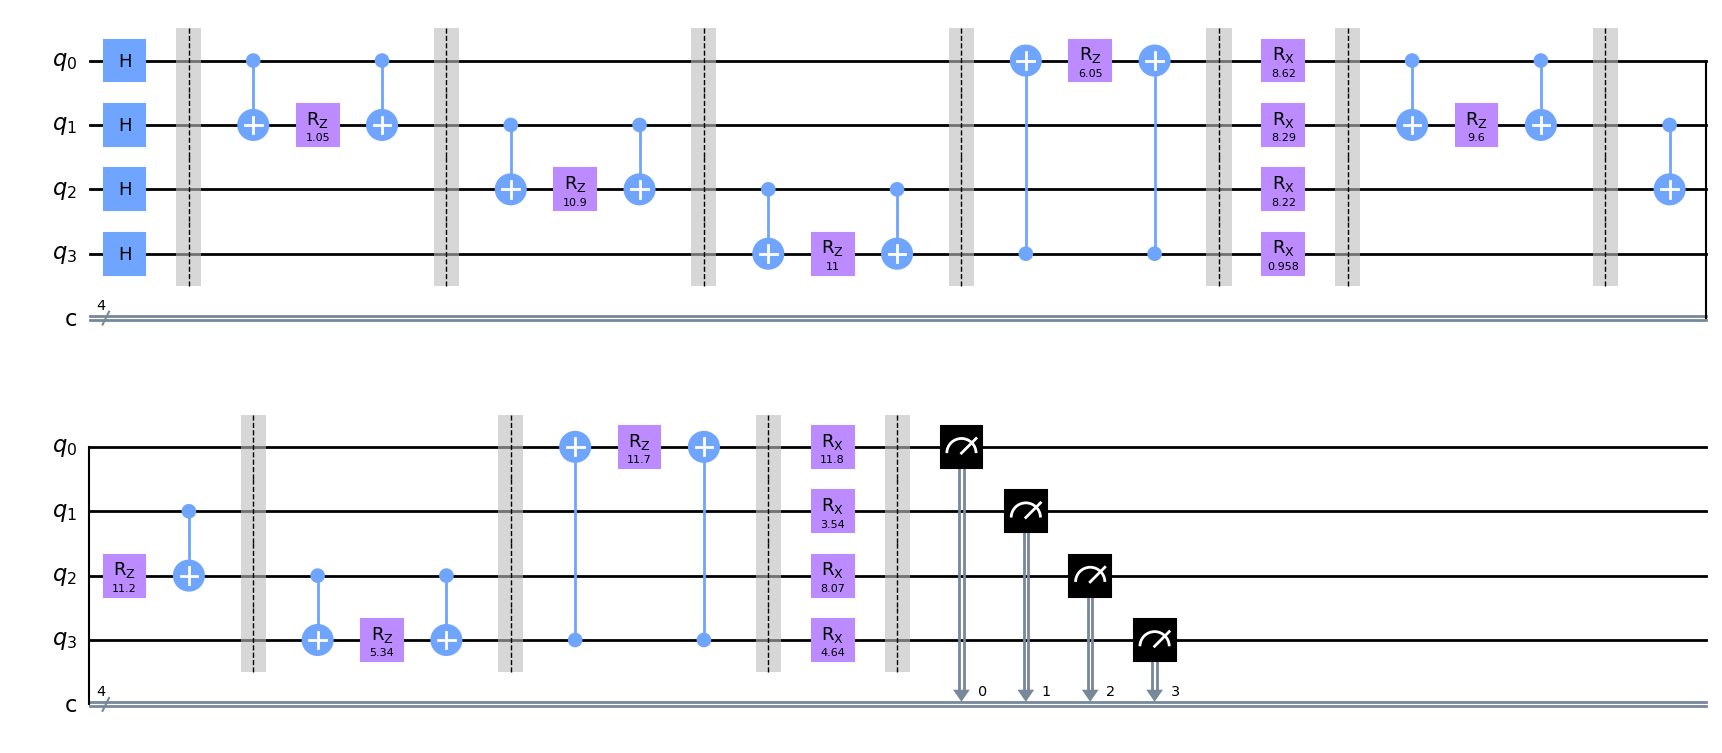

In [7]:
qaoa.draw()

当我们设置 `n_layers=2` 时，可以得到最优目标函数值 $C=4$。绘制结果

{'0101': 176, '0010': 45, '1100': 61, '1010': 172, '1101': 47, '0110': 58, '0011': 63, '1000': 44, '1111': 20, '1110': 60, '1011': 34, '1001': 59, '0111': 55, '0000': 24, '0100': 60, '0001': 46}
最佳分割方案0101


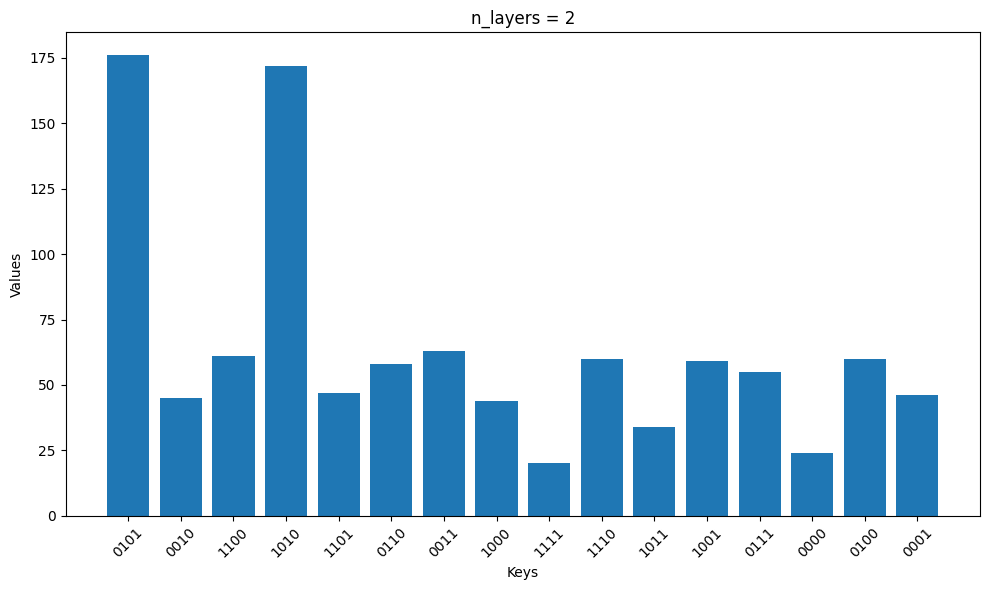

In [8]:
res = qaoa.measure()
print(res)
max_key = max(res, key=res.get)
print('最佳分割方案'+str(max_key))

labels = list(res.keys())
values = list(res.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('n_layers = 2')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



我们可以绘制优化后电路的测量分布。正如对这个图的预期，划分 0101 和 1010 的测量频率最高。

# 参考文献（References）
[1] Farhi E, Goldstone J, Gutmann S. A quantum approximate optimization algorithm[J]. arXiv preprint arXiv:1411.4028, 2014.